In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# sklearn stuff
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin
from sklearn.datasets import make_regression

# model functionality and validation
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# regressor models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

In [118]:
# inflation (CPI) in the USA
# 2010	1.6
# 2009	-0.4
# 2008	3.8
# 2007	2.8
# 2006	3.2
# 2005	3.4
# 2004	2.7

cpi = pd.read_csv("../data/CPIAUCNS.csv")
# https://fred.stlouisfed.org/series/CPIAUCNS

In [119]:
cpi.loc[:,"cpi"] = cpi.loc[:,"CPIAUCNS"] / 198.3

# reverse the order of the np_cpi and then we won't have to do anything fancy
# but just feed in the months since sold
np_cpi = np.array(cpi.cpi.values)[::-1]
print np_cpi[50]

1.02118003026


In [120]:
def figure_months(years_since_sale, month_sold):
    '''
    Takes in how many years since sale and what month sold
    Figures out how long it has been since sale using assumption that last
    sale in data took place month 7 of 2010.  Therefore a house sold 7-2010
    would have a value of 0. A house sold on 6-2009 should have a value of 13
    
    Returns integer that reflects the number of months since a house was sold
    '''
    # variable with guardian variable to help indicate that something went wrong
    out_months = -1
    
    # handle case that the house was sold in the last year of the sample
    if years_since_sale == 0:
        # the latest date of sale from the sample is month 7 at years since sold 0
        out_months = 7 - month_sold
        
        return out_months
    
    else:
        # years_since_sale >= 1
        #
        # 6-2009 (1yr 6mo) => 6 + 7 => 13 
        # 3-2007 (3yr 3mo) => 9 + 24 + 7 => 40
        out_months = (years_since_sale - 1) * 12 + (12 - month_sold) + 7
        
        return out_months
    
def simple_inflation_adjuster(mso, cpis):
    '''
    Looks up CPI multiplier sourced from the St Louis Federal Reserve
    
    Returns CPI multiplier (float, 1.0 - ~1.10)
    '''
    
    return cpis[int(mso)]
    
def inflation_adjuster(mso):
    '''
    Input variable 'mso' = months_since_sold
    
    Figure out how much the sales price multiplier should be as a percent
    ie sold 2010 month 7 = 1.00, 2010 month 1 = 1.02 (or whatever) 
    First sale in data is 1-2006
    
    This is probably going to be off by 10% but still might be a good estimate
    Might consider using sales market appreciation but then that might be a form of
    data leakage, so right now just trying to use inflation
    
    returns float that is the multiplier 1.x that would adjust the past price to 7-2010 dollars
    '''
    
    # inflation (CPI) in the USA
    # 2010	1.6
    # 2009	-0.4
    # 2008	3.8
    # 2007	2.8
    # 2006	3.2
    
    # house sold on:  result:
    # 1-2006          1.032 * 1.028 * 1.038 * .996 * (1.016 / 7)
    # 7-2010          1.0
    # 1-2010          1.0 + (6* 0.016/12.0)
    y0 = 3.2/12.0/100.0  # 2006
    y1 = 2.8/12.0/100.0  # 2007
    y2 = 3.8/12.0/100.0  # 2008
    y3 = -0.4/12.0/100.0 # 2009
    y4 = 1.6/12.0/100.0  # 2010
    
    # figure out if the date is bigger than the last year
    if mso > 7:
        # do something
        
        # add inflation for 2010 and remove 7 months from mso to make arithmetic easier
        # mso is 0 based so actually subtract 6
        scaler = 1.0 + y4 * 7.0
        mso -= 7
        
        if mso > 12:
            # must be more than 1.5 years back
            
            # adjust scaler for 2009 inflation and keep going
            mso -= 12
            scaler *= (1.0 + y3 * 12)
            
            if mso > 12:
                # must older in 2008 now
                # adjust scaler for 2008 inflation and keep going
                mso -= 12
                scaler *= (1.0 + y2 * 12)
                
                if mso > 12:
                    # sale must be older than 2007 now
                    # adjust scaler for 2007 inflation and keep going
                    mso -= 12
                    scaler *= (1.0 + y1 * 12)
                    
                    if mso > 12:
                        print "something went wrong with figuring out month inflation because months_since_sold is too high!"
                        
                    else:
                        scaler *= (1.0 + y0 * mso)
                        return scaler
                    
                else:
                    # must have been sold in 2007, mso <= 12
                    scaler *= (1.0 + y1 * mso)
                    return scaler
            
            else:
                # must have been sold in 2008, mso <= 12
                scaler *= (1.0 + y2 * mso)
                return scaler
        else:
            # must have been sold in 2009, mso <= 12
            scaler *= (1.0 + y3 * mso)
            return scaler
    else:
        # otherwise it's easy, just figure out partial inflation for 2010
        return 1.0 + (mso * y4)
    
1.032 * 1.028 * 1.038 * .996 * (1.0 + (0.016 / 12.0) * 6)

1.105579649470464

In [138]:
# data pipeline

# read in file
raw_data = pd.read_csv("../data/AmesHousing.csv", "~")

# see what has been loaded
# print raw_data.keys()

'''u'Order', u'PID', u'MS SubClass', u'MS Zoning', u'Lot Frontage',
       u'Lot Area', u'Street', u'Alley', u'Lot Shape', u'Land Contour',
       u'Utilities', u'Lot Config', u'Land Slope', u'Neighborhood',
       u'Condition 1', u'Condition 2', u'Bldg Type', u'House Style',
       u'Overall Qual', u'Overall Cond', u'Year Built', u'Year Remod/Add',
       u'Roof Style', u'Roof Matl', u'Exterior 1st', u'Exterior 2nd',
       u'Mas Vnr Type', u'Mas Vnr Area', u'Exter Qual', u'Exter Cond',
       u'Foundation', u'Bsmt Qual', u'Bsmt Cond', u'Bsmt Exposure',
       u'BsmtFin Type 1', u'BsmtFin SF 1', u'BsmtFin Type 2', u'BsmtFin SF 2',
       u'Bsmt Unf SF', u'Total Bsmt SF', u'Heating', u'Heating QC',
       u'Central Air', u'Electrical', u'1st Flr SF', u'2nd Flr SF',
       u'Low Qual Fin SF', u'Gr Liv Area', u'Bsmt Full Bath',
       u'Bsmt Half Bath', u'Full Bath', u'Half Bath', u'Bedroom AbvGr',
       u'Kitchen AbvGr', u'Kitchen Qual', u'TotRms AbvGrd', u'Functional',
       u'Fireplaces', u'Fireplace Qu', u'Garage Type', u'Garage Yr Blt',
       u'Garage Finish', u'Garage Cars', u'Garage Area', u'Garage Qual',
       u'Garage Cond', u'Paved Drive', u'Wood Deck SF', u'Open Porch SF',
       u'Enclosed Porch', u'3Ssn Porch', u'Screen Porch', u'Pool Area',
       u'Pool QC', u'Fence', u'Misc Feature', u'Misc Val', u'Mo Sold',
       u'Yr Sold', u'Sale Type', u'Sale Condition', u'SalePrice'],'''

# select most likely key features
data = raw_data[["SalePrice", "1st Flr SF", "2nd Flr SF", "MS Zoning", "MS SubClass", "Lot Frontage", "Lot Area", 
                 "Land Contour", "Bldg Type", "House Style", "Overall Qual", "Overall Cond", "Year Built", 
                 "Year Remod/Add", "Bsmt Qual", "Bsmt Cond", "Heating", "Central Air", "Full Bath", 
                 "Half Bath", "Bedroom AbvGr", "Fireplaces", "Garage Type", "Garage Cars", "Pool Area", 
                 "Pool QC", "Yr Sold"]]

# ensure we've loaded what we want
data.keys()

# convert to a simplified dataframe for initial work
simple_data = data[["SalePrice", "1st Flr SF", "2nd Flr SF", "Year Built", "Full Bath", "Half Bath", 
                    "Bedroom AbvGr", "Garage Cars", "Yr Sold", "Overall Qual", "Lot Area", "Lot Frontage",
                   "Pool Area", "Fireplaces", "MS SubClass"]]

##############################################################################
# Add year sold                                                      #########
##############################################################################
simple_data.loc[:,"Yr Sold"] = raw_data["Yr Sold"]

print "year_sold", sorted(simple_data.loc[:,"Yr Sold"].unique())

# figure out how long since sale (in years)
simple_data.loc[:,"yrs_since_sold"] = 2010 - simple_data.loc[:,"Yr Sold"]
print "years since sold: ", simple_data["yrs_since_sold"].unique()

# 'Yr Sold' is probably redundant info now
# simple_data.pop("Yr Sold")

##############################################################################
# Add zoning flags                                                   #########
##############################################################################

raw_data.loc[:,"MS Zoning"].unique()

boink = pd.get_dummies(raw_data.loc[:,"MS Zoning"])
# array(['RL', 'RH', 'FV', 'RM', 'C (all)', 'I (all)', 'A (agr)'], dtype=object)
boink.columns = ["zoning_rl", "zoning_rh", "zoning_fv", "zoning_rm", "zoning_c_all", "zoning_i_all", "zoning_a_all"]

simple_data = pd.concat((simple_data, boink), axis=1)

##############################################################################
# Add month sold                                                     #########
##############################################################################
simple_data.loc[:,"Mo Sold"] = raw_data["Mo Sold"]

temp = simple_data[simple_data.loc[:,"Yr Sold"] == 2006]
print "2006 sale months", sorted(temp["Mo Sold"].unique())

# info = simple_data[simple_data["yrs_since_sold"] == 0]
# year 0 month sold: [5 6 4 3 1 2 7]
# print "year 0 month sold:", info["Mo Sold"].unique()
#
# Therefore most recently sold house would be yrs_since_sold == 0 and 'Mo Sold' == 7
#
# to figure out a "months_since_sale" we'd have to do it like 12 - mo_sold + 
# yrs_since_sold * 12

# simple_data.loc[:,"mon_since_sold"] = 12 - simple_data.loc[:, "Mo Sold"] + 12 * simple_data.loc[:, "yrs_since_sold"]

# df['newcolumn'] = df.apply(lambda x: fxy(x['A'], x['B']), axis=1)

simple_data.loc[:, "mon_since_sold"] = simple_data.apply(lambda x: figure_months(x["yrs_since_sold"], x["Mo Sold"]), axis=1)

print "months since sold unique: ", sorted(simple_data.loc[:,"mon_since_sold"].unique())

simple_data.loc[:, "cpi_adjustment"] = simple_data.apply(lambda x: simple_inflation_adjuster(x["mon_since_sold"], np_cpi), axis=1)
print "cpi_adjustment:", sorted(simple_data.loc[:, "cpi_adjustment"].unique())

##############################################################################
# Add total rooms AbvGrnd                                            #########
##############################################################################

simple_data.loc[:,"TotRms AbvGrd"] = raw_data["TotRms AbvGrd"]
# simple_data.loc[:,"bedroom_to_room_ratio"] = 

##############################################################################
# Years Since Update                                                 #########
##############################################################################

simple_data.loc[:,"yrs_since_update"] = 2010 - data["Year Remod/Add"] + np.random.normal(-0.001, .001, size=1)

##############################################################################
# Overall Cond                                                       #########
##############################################################################

temp = data["Overall Cond"]
print temp.unique()
# [5 6 7 2 8 4 9 3 1]
oc_dum = pd.get_dummies(temp)
key_list = temp.unique()
new_key_list = ["oc_" + str(key) for key in key_list]
oc_dum.columns = [new_key_list]
print oc_dum.head()
simple_data = pd.concat((simple_data, oc_dum), axis=1)
# simple_data.pop("Overall Cond")

##############################################################################
# MS SubClass                                                        #########
##############################################################################

# print simple_data["MS SubClass"].unique()
# [ 20  60 120  50  85 160  80  30  90 190  45  70  75  40 180 150]
ms_sub = pd.get_dummies(simple_data["MS SubClass"])

key_list = simple_data["MS SubClass"].unique()

new_key_list = ["ms_sub_" + str(key) for key in key_list]
ms_sub.columns = [new_key_list]
# print ms_sub
simple_data = pd.concat((simple_data, ms_sub), axis=1)
simple_data.pop("MS SubClass")


##############################################################################
# basement stuff                                                     #########
##############################################################################

# print data["Bsmt Qual"].unique()

boink = pd.get_dummies(data["Bsmt Qual"])
# [u'Ex', u'Fa', u'Gd', u'Po', u'TA']
boink.columns = ["bsmt_qual_ex", "bsmt_qual_fa", "bsmt_qual_gd", "bsmt_qual_po", "bsmt_qual_ta" ]

simple_data = pd.concat((simple_data, boink), axis=1)

##############################################################################
# pool data                                                          #########
##############################################################################

# has_pool = np.array(simple_data.loc[:,"Pool Area"] > 0)
# has_pool_df = pd.DataFrame(has_pool, columns=["has_pool"])
# simple_data = pd.concat((simple_data, has_pool_df), axis=1)


##############################################################################
# use the oneHot encoder to create dummy columns for overall quality #########
##############################################################################
encoder = OneHotEncoder()
temp = simple_data["Overall Qual"]
overall_qual_dummies = encoder.fit_transform(temp.values.reshape(-1, 1))
overall_qual_dummies = overall_qual_dummies.toarray()
print "overall_qual_dummies shape:", overall_qual_dummies.shape

oq_dummies = pd.DataFrame(overall_qual_dummies, columns=["oq_1", "oq_2", "oq_3", "oq_4", "oq_5", "oq_6", 
                                                         "oq_7", "oq_8", "oq_9", "oq_10"])
# print oq_dummies.head()

simple_data = pd.concat((simple_data, oq_dummies), axis=1)
simple_data.pop("Overall Qual")


# Fuzzing Quality seemed to hurt accuracy, perhaps because there wasn't a super dominant feature
# print simple_data.keys()
# simple_data.loc["Overall Qual"] = simple_data[simple_data["Overall Qual"] + np.random.uniform(-0.001, 0.001, size=len(simple_data))]
# simple_data.loc[:, "Overall Qual"] += np.random.normal(-0.001, 0.001, size=1)


##############################################################################
# Figure out Square footage information                              #########
##############################################################################
# fill in nan for 2nd floor square feet with zeros, which makes sense
simple_data.loc[:, "2nd Flr SF"].fillna(0, inplace=True)

# calculate simple square footage
square_feet = simple_data.loc[:,"1st Flr SF"] + simple_data.loc[:,"2nd Flr SF"]

# add this to the data frame then clean up the data frame some
simple_data = pd.concat((simple_data, square_feet), axis=1)
simple_data.pop(0)
simple_data.drop("1st Flr SF", axis=1, inplace=True)
simple_data.drop("2nd Flr SF", axis=1, inplace=True)

# fix nans
simple_data["Garage Cars"].fillna(0, inplace=True)

simple_data["Lot Frontage"].fillna(simple_data["Lot Frontage"].mean(), inplace=True)

##############################################################################
# Create "lot_ratio" which is "Lot Area" / "Lot Frontage"            #########
##############################################################################
simple_data.loc[:, "lot_length"] = simple_data.loc[:,"Lot Area"] / (simple_data.loc[:, "Lot Frontage"] * 1.0)

simple_data.loc[:, "lot_ratio"] = simple_data.loc[:,"Lot Frontage"] / (simple_data.loc[:, "lot_length"] * 1.0)
simple_data.pop("lot_length")

##############################################################################
# Bathroom feature manipulation                                      #########
##############################################################################
# combine bathroom stats
# simple_data.loc[:, "total_baths"] = simple_data.loc[:, "Full Bath"] + simple_data.loc[:, "Half Bath"]

# simple_data["total_baths"] = simple_data["total_baths"].mask(simple_data["total_baths"] == 0, 0.1)

# simple_data.loc[:, "bed_to_bath"] = simple_data.loc[:, "Bedroom AbvGr"] / (simple_data.loc[:, "total_baths"] * 1.0)

############################################################################## 
# Pop out pricing labels                                             #########
##############################################################################
Y = simple_data.loc[:,"SalePrice"] * simple_data.loc[:,"cpi_adjustment"]

# create log prices version
log_Y = np.log10(Y)

##############################################################################
# Print out basic info for constructed dataframe                     #########
##############################################################################
simple_data.pop("SalePrice")

print simple_data.describe()

print
print simple_data.info()

simple_df = simple_data

############################################################################## 
# Scale/standardize features                                         #########
##############################################################################
scaler = StandardScaler()
simple_data = scaler.fit_transform(simple_data)

##############################################################################
# Track Feature Engineering Evolution                                #########
##############################################################################

# try to fuzz "Overall Qual" so that it can't totally drill in on any particular value
# Starting ensemble with "simple_data" 
# Mean RMSE of 10 Runs:54667.0
#
# Add "Overall Qual" feature
# Mean RMSE of 10 Runs:46235.5
#
# Fuzzed "Overall Qual" Feature
# Mean RMSE of 10 Runs:46102.1
#
# Dummified "Overall Qual" feature
# Mean RMSE of 10 Runs:46572.3
# really helped RandomForests and LinearRegression though
#
# Tuned Gradient Boosting Hyper Parameters with quality dummies disabled
# Mean RMSE of 10 Runs:37670.7
#
# Enabled Dummified overall quality
# Mean RMSE of 10 Runs:38282.8
#
# Modified splitting to keep 20% of original data for use as validation set to prevent
# overall overfitting because the model tuning is being run so many times
# Mean RMSE of 10 Runs:38118.5
#
# Include "Lot Area" feature
# Mean RMSE of 10 Runs:36766.1
#
# Include "Lot Frontage" feature
# Mean RMSE of 10 Runs:34989.0
#
# Create "lot_length" feature "Lot Area" / "Lot Frontage"
# Mean RMSE of 10 Runs:37455.6
#
# Create "lot_ratio" which is "Lot Frontage" / "lot_length"
# Mean RMSE of 10 Runs:35728.2
#
# Create "total_baths"
# Mean RMSE of 10 Runs:36547.2
#
# Tuned DecisionTree max_depth hyper parameter to 7
# Mean RMSE of 10 Runs:34161.9
#
# Fireplaces
# Mean RMSE of 10 Runs:34219.6
#
# bed_to_bath ratio
# Mean RMSE of 10 Runs:33950.7
#
# basement quality dummy columns
# Mean RMSE of 10 Runs:34915.2
#
# removed basement quality dummy columns
# Mean RMSE of 10 Runs:34795.2
#
# Added Ridge model to ensemble, re-enabled pool and basement
# Mean RMSE of 10 Runs:34116.1
#
# Standardize the data
# Mean RMSE of 10 Runs:32079.9
#
# Add log transformation of prices
# Unsure if it helped but seemed to cause a lot of problems, weirdly
#
# Add MS Subclass
# Mean RMSE of 10 Runs:35276.2
#
# Dummify MS Subclass (forgot to pop it so the base column for MS Subclass still present)
# Mean RMSE of 10 Runs:32194.4
#
# Popped MS Subclass base (went up but probably just variance)
# Mean RMSE of 10 Runs:33467.0
#
# Removed decision tree from ensemble since it's fairly similar to random forests
# Mean RMSE of 10 runs: 33179.8
#
# Make dummy columns for 'Overall Condition' and add that to simple_data
# Mean RMSE of 10 Runs:33015.1
#
# Linear regression model still periodically 'exploding' 
# Linear RMSE: 1.15322876772e+16
# 
# Add rooms above ground, year sold, month sold:
# Mean RMSE of 10 Runs:32518.3
#
# Add 'years_since_sold":
# Mean RMSE of 10 Runs:33510.4

year_sold [2006, 2007, 2008, 2009, 2010]
years since sold:  [0 1 2 3 4]
2006 sale months [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
months since sold unique:  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0]
cpi_adjustment: [1.0, 1.0020171457387794, 1.0075642965204237, 1.016137165910237, 1.0176500252143217, 1.0207564296520424, 1.0211800302571861, 1.0231971759959657, 1.0262178517397882, 1.0262228946041352, 1.0282400403429148, 1.0355622793746848, 1.0422894604135147, 1.0484972264246091, 1.0486585980837115, 1.0504236006051437, 1.0506908724155319, 1.0513867876954111, 1.0536359051941502, 1.059183055975794, 1.0598940998487141, 1.0601512859304083, 1.064447806354009, 1.0647655068078667, 1.0675390821986888, 1.0700605143721633, 1.07

In [6]:
32194 / Y.mean()

0.17806803968983165

## Function Definitions:

In [122]:
def make_data_splits(X, Y):
    '''
    Take data in and split it into 3 sets for a 2 stage stacked ensemble
    return 3 X_set splits and 3 y_set splits like:
    X_train1, X_train2, X_test, y_train1, y_train2, y_test
    '''
    # split the data for train and test
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)

    y_train = np.array(y_train).reshape(-1, 1)
    y_test = np.array(y_test).reshape(-1, 1)

#     print "y_train", y_train.shape
#     print "X_train", X_train.shape
#     print "y_test", y_test.shape
#     print "X_test", X_test.shape

    # subdivide again for 2 stage ensemble
    X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, test_size=0.5)

    y_train1 = y_train1.reshape(-1, 1)
    y_train2 = y_train2.reshape(-1, 1)
    
    return X_train1, X_train2, X_test, y_train1, y_train2, y_test

def run_multi_stack(X, y, log_y=False):
    '''
    Simply take the average prediction of several models and use that for a prediction
    
    Returns the RMSE resulting from that
    '''
    
    # tuned stage 1 gradient boosting with n_estimators 10,000 learning rate 0.001
    # Mean RMSE of 10 Runs:38670.5

    # tuned stage 1 gradient boosting with n_estimators 1,000 learning rate 0.01
    # Mean RMSE of 10 Runs:38626.6

    # tuned stage 2 gradient boosting with n_estimators 1,000 learning rate 0.01
    # Mean RMSE of 10 Runs:37670.7
    
    # tuned DecisionTreeRegressor with max depth from 1 to 100 and ~7 was the minimum
    
    # prevent overfitting on eval type data esp since we're doing a junky for loop for multiple
    # fold testing

    # add in log y transformation
    
    X_train, X_eval, y_train, y_eval = train_test_split(X, y, random_state=42, test_size=0.2)
    
    # split the data for train and test
    X_train1, X_train2, X_test, y_train1, y_train2, y_test = make_data_splits(X_train, y_train)
    
    m1 = SVR(C=2.0)
    m2 = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
    m3 = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01)
    m4 = LinearRegression(fit_intercept=True)
    m5 = DecisionTreeRegressor(max_depth=7)
    m6 = Ridge()
    
    models = [m2, m3, m4, m6]

    preds = np.zeros((len(y_train2), len(models)))
    for idx, model in enumerate(models):
        # print "Fitting {}...".format(model.__class__.__name__)
        if log_y == True:
            model.fit(X_train1, np.log10(y_train1).ravel())
        else:
            model.fit(X_train1, y_train1.ravel())
        
        # print "Predicting {}...".format(model.__class__.__name__)
        results = model.predict(X_train2).ravel()
        
        preds[:,idx] = results
        
#     print "Linear Regression coefs:", m4.coef_
        

    # figure out RMSE of the average of the preds
    rmses = []
    for x in range(len(models)):
#         if x == 2:
#             print "max in preds[{:2d}]:{}".format(x, preds[:,x].max())

#             print "model coefs:"
#             for att, coef in zip(simple_df.keys(), models[x].coef_):
#                 print "{:<20}    {:12.0f}".format(att, coef)
        
        if log_y == True:
            rmse = np.sqrt(mean_squared_error(10**preds[:,x], y_train2.ravel()))
        else:
            rmse = np.sqrt(mean_squared_error(preds[:,x], y_train2.ravel()))
            
        rmses.append(rmse)
    
#     print "\n\n"
    print "First stage RMSEs:"
    print "{:<20} {:<20} {:<20} {:<20}".format("Random Forest", "Gradient Boosting", 
                                               "Linear Regression", "Ridge")
    print "{:<20} {:<20} {:<20} {:<20}".format(rmses[0], rmses[1], rmses[2], rmses[3])
#     print "\n\n"
    
    # second stage model that takes predictions from models trained on first whack of data
    blender = GradientBoostingRegressor(n_estimators=10000, learning_rate=0.001)
    
    # fit blender
    if log_y == True:
        blender.fit(preds, np.log10(y_train2))
    else:
        blender.fit(preds, y_train2)
        
    # now take in the whole pipeline on the test set
    
    # first get predictions on test set from the stage 1 models
    final_s1_preds = np.zeros((len(y_test), len(models)))
    
    for idx, model in enumerate(models):
        #print "Predicting Test data with {}...".format(model.__class__.__name__)
        results = model.predict(X_test).ravel()
        
        final_s1_preds[:,idx] = results
    
    final_preds = blender.predict(final_s1_preds)
    
    # convert back to normal, non-log10, prices
    if log_y == True:
        final_preds = 10**final_preds
    # else don't have to do anything
    
    rmse = np.sqrt(mean_squared_error(final_preds, y_test))
    
    print "Final RMSE:{:6.1f}\n".format(rmse)
    
    return rmse

## Run model 10 times to get mean RMSE

In [139]:
num_runs = 10

outcomes = np.zeros((num_runs,1))

for x in range(num_runs):
    outcomes[x] = run_multi_stack(simple_data, Y)
    
print "\nMean RMSE of 10 Runs:{:6.1f}".format(outcomes.mean())

First stage RMSEs:
Random Forest        Gradient Boosting    Linear Regression    Ridge               
33665.5018359        33632.7801854        3.347445432e+15      41358.2499838       
Final RMSE:36529.0

First stage RMSEs:
Random Forest        Gradient Boosting    Linear Regression    Ridge               
34646.5281034        32315.6077295        2.21595872957e+17    32834.2405659       
Final RMSE:36450.2

First stage RMSEs:
Random Forest        Gradient Boosting    Linear Regression    Ridge               
32712.9508779        31054.7596069        9.5479508091e+14     31854.8662662       
Final RMSE:35974.7

First stage RMSEs:
Random Forest        Gradient Boosting    Linear Regression    Ridge               
35519.120633         33804.3924356        1.64943176389e+17    34578.7569394       
Final RMSE:34620.4

First stage RMSEs:
Random Forest        Gradient Boosting    Linear Regression    Ridge               
33529.4562378        34828.9883515        1.34565454525e+16    35631.

In [9]:
# Mean RMSE of 10 Runs:33457.0
# Mean RMSE of 10 Runs:35447.6
# Mean RMSE of 10 Runs:37312.2
# Mean RMSE of 10 Runs:37174.7

In [34]:
X_core, X_eval, y_core, y_eval = train_test_split(simple_data.values, Y, random_state=42, test_size=0.2)

errors = []

for ida in range(1, 21):
    RMSEs = []

    for idx in range(5):
        X_train, X_test, y_train, y_test = train_test_split(X_core, y_core, test_size=0.3)
        
        #print X_train.shape, y_train.shape, X_test.shape, y_test.shape

        model = DecisionTreeRegressor(max_depth=ida)
        model.fit(X_train, y_train)

        preds = model.predict(X_test)

        RMSE = np.sqrt(mean_squared_error(preds, y_test))

        RMSEs.append(RMSE)

    print RMSEs
    print np.array(RMSEs).mean()
    errors.append(np.array(RMSEs).mean())

errors1 = []

for ida in range(1, 21):
    RMSEs = []

    for idx in range(5):
        X_train, X_test, y_train, y_test = train_test_split(X_core, y_core, test_size=0.3)
        
        #print X_train.shape, y_train.shape, X_test.shape, y_test.shape

        model = DecisionTreeRegressor(max_depth=ida)
        model.fit(X_train, y_train)

        preds = model.predict(X_test)

        RMSE = np.sqrt(mean_squared_error(preds, y_test))

        RMSEs.append(RMSE)

    print RMSEs
    print np.array(RMSEs).mean()
    errors1.append(np.array(RMSEs).mean())
    

errors2 = []

for ida in range(1, 21):
    RMSEs = []

    for idx in range(5):
        X_train, X_test, y_train, y_test = train_test_split(X_core, y_core, test_size=0.3)
        
        #print X_train.shape, y_train.shape, X_test.shape, y_test.shape

        model = DecisionTreeRegressor(max_depth=ida)
        model.fit(X_train, y_train)

        preds = model.predict(X_test)

        RMSE = np.sqrt(mean_squared_error(preds, y_test))

        RMSEs.append(RMSE)

    print RMSEs
    print np.array(RMSEs).mean()
    errors2.append(np.array(RMSEs).mean())

[66491.303814985804, 63087.950567560976, 62068.821391160214, 59388.042564430056, 62803.097094610268]
62767.8430865
[54676.81171070275, 55950.510780058401, 52680.275102326195, 53239.569765994762, 54364.761710390019]
54182.3858139
[49977.153435921187, 46163.022819604324, 45169.931956820285, 50432.590951483158, 48689.59979593246]
48086.459792
[46943.629496220412, 44739.875363640735, 45381.513601963517, 41868.100126475001, 44870.413239372341]
44760.7063655
[42172.26308847365, 41757.578455939489, 44855.718359580751, 46313.485969653557, 42900.614114875076]
43599.9319977
[40658.028225076108, 41369.538332563381, 40000.026020622689, 40076.514299341696, 40778.800680581735]
40576.5815116
[38484.719270442547, 39384.36872474019, 37257.606635911718, 41359.705440522979, 38651.130604922335]
39027.5061353
[39971.885145395099, 44037.283597529095, 44127.415233917134, 42526.695743903423, 44729.757535859164]
43078.6074513
[44905.483586393719, 41266.221544521461, 40958.245002975091, 40560.544615888357, 4381

(35000, 65000)

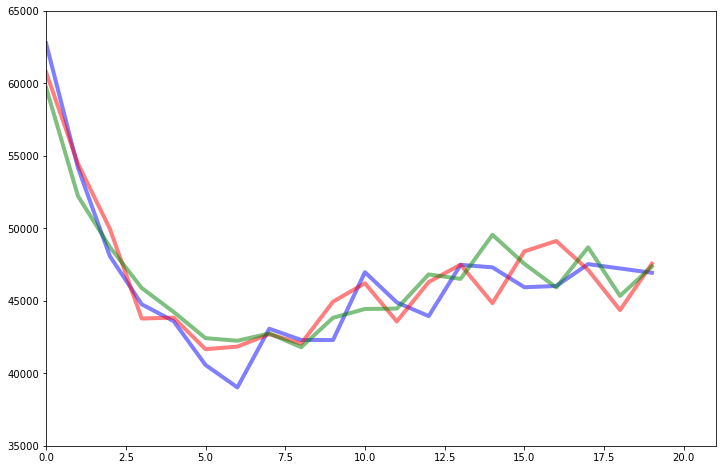

In [37]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(errors, lw=4, color="blue", alpha=0.5)
ax.plot(errors1, lw=4, color="red", alpha=0.5)
ax.plot(errors2, lw=4, color="green", alpha=0.5)
ax.set_xlim(0, 21)
ax.set_ylim(35000, 65000)

In [44]:
bix = LinearRegression()

In [46]:
bix.fit(simple_data, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [47]:
bix.coef_

array([  5.40908228e+03,   4.14371252e+15,   3.76668142e+15,
         3.13511647e+03,   9.15121999e+03,  -8.72455173e+02,
         5.88843586e+03,   8.00804294e+03,  -3.92701837e+03,
         1.06585000e+04,   1.78939844e+04,   2.39987500e+03,
         1.39647500e+04,   5.95562500e+02,   1.03308125e+04,
         4.42071875e+03,  -5.26547231e+14,  -9.47785515e+14,
        -1.65481365e+15,  -3.80476414e+15,  -6.41391501e+15,
        -6.17361527e+15,  -5.76182296e+15,  -4.62502465e+15,
        -2.67496131e+15,  -1.45906665e+15,  -4.41565625e+03,
        -6.02852450e+15])

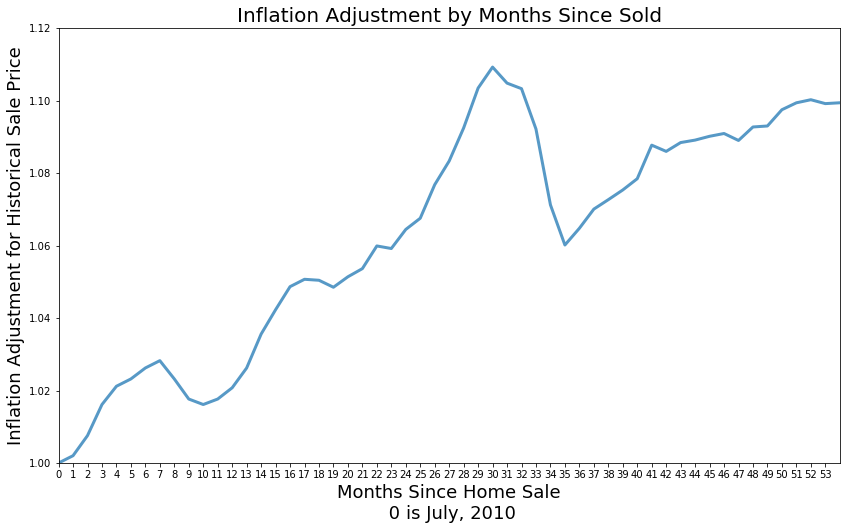

In [116]:
fig, zx = plt.subplots(figsize=(14,8))
months = sorted(simple_df.loc[:,"mon_since_sold"].unique(), reverse=True)
adjustments = np_cpi

zx.plot(months, adjustments, lw=3, alpha=0.75)
# zx.plot(months, np.array(cpi.cpi), lw=3, alpha=0.75, color="red")
zx.set_title("Inflation Adjustment by Months Since Sold", size=20)
zx.set_xlabel("Months Since Home Sale\n 0 is July, 2010", size=18)
zx.set_ylabel("Inflation Adjustment for Historical Sale Price", size=18)
zx.set_xlim(0, 54)
zx.set_ylim(1.0, 1.12)
zx.set_xticks(np.arange(54))

In [124]:
raw_data.keys()

Index([u'Order', u'PID', u'MS SubClass', u'MS Zoning', u'Lot Frontage',
       u'Lot Area', u'Street', u'Alley', u'Lot Shape', u'Land Contour',
       u'Utilities', u'Lot Config', u'Land Slope', u'Neighborhood',
       u'Condition 1', u'Condition 2', u'Bldg Type', u'House Style',
       u'Overall Qual', u'Overall Cond', u'Year Built', u'Year Remod/Add',
       u'Roof Style', u'Roof Matl', u'Exterior 1st', u'Exterior 2nd',
       u'Mas Vnr Type', u'Mas Vnr Area', u'Exter Qual', u'Exter Cond',
       u'Foundation', u'Bsmt Qual', u'Bsmt Cond', u'Bsmt Exposure',
       u'BsmtFin Type 1', u'BsmtFin SF 1', u'BsmtFin Type 2', u'BsmtFin SF 2',
       u'Bsmt Unf SF', u'Total Bsmt SF', u'Heating', u'Heating QC',
       u'Central Air', u'Electrical', u'1st Flr SF', u'2nd Flr SF',
       u'Low Qual Fin SF', u'Gr Liv Area', u'Bsmt Full Bath',
       u'Bsmt Half Bath', u'Full Bath', u'Half Bath', u'Bedroom AbvGr',
       u'Kitchen AbvGr', u'Kitchen Qual', u'TotRms AbvGrd', u'Functional',
       u'Fi

In [213]:
# raw_data.loc[:, "Mas Vnr Type"].fillna("None", inplace=True)

describe_this("Total Bsmt SF")

[ 1080.   882.  1329. ...,  1381.   757.  1003.]
count    2929.000000
mean     1051.614544
std       440.615067
min         0.000000
25%       793.000000
50%       990.000000
75%      1302.000000
max      6110.000000
Name: Total Bsmt SF, dtype: float64


In [143]:
raw_data.loc[:,"Roof Style"].unique()

boink = pd.get_dummies(raw_data.loc[:,"Roof Style"])
# array(['Hip', 'Gable', 'Mansard', 'Gambrel', 'Shed', 'Flat'], dtype=object)
boink.columns = ["roof_hip", "roof_gable", "roof_mansard", "roof_gambrel", "roof_shed", "roof_flat"]

simple_df = pd.concat((simple_df, boink), axis=1)

print raw_data.loc[:,"Roof Matl"].unique()
boink = pd.get_dummies(raw_data.loc[:, "Roof Matl"])
boink.columns = ["roof_mat_compshg", "roof_mat_wdshake", "roof_mat_targrv", "roof_mat_wdshngl", "roof_mat_membran", "roof_mat_clytile", "roof_mat_roll", "roof_mat_metal"]
simple_df = pd.concat((simple_df, boink), axis=1)

['CompShg' 'WdShake' 'Tar&Grv' 'WdShngl' 'Membran' 'ClyTile' 'Roll' 'Metal']


In [154]:
# print raw_data.loc[:,"Kitchen Qual"].unique()

boink = pd.get_dummies(raw_data.loc[:,"Kitchen Qual"])
keys = boink.keys()

# print boink.head()
# print keys
# Index([u'Ex', u'Fa', u'Gd', u'Po', u'TA'], dtype='object')
new_keys = ["kqual_" + key.lower() for key in keys]
boink.columns = new_keys
# print boink.head()
# boink.columns = ["kqual_ta", "kqual_gd", ]`

   Ex  Fa  Gd  Po  TA
0   0   0   0   0   1
1   0   0   0   0   1
2   0   0   1   0   0
3   1   0   0   0   0
4   0   0   0   0   1
Index([u'Ex', u'Fa', u'Gd', u'Po', u'TA'], dtype='object')
   kqual_ex  kqual_fa  kqual_gd  kqual_po  kqual_ta
0         0         0         0         0         1
1         0         0         0         0         1
2         0         0         1         0         0
3         1         0         0         0         0
4         0         0         0         0         1


In [155]:
print raw_data.loc[:,"Neighborhood"].unique()
boink = pd.get_dummies(raw_data.loc[:,"Neighborhood"])
keys = boink.keys()
new_keys = ["neigh_" + key.lower() for key in keys]
boink.columns = new_keys

['NAmes' 'Gilbert' 'StoneBr' 'NWAmes' 'Somerst' 'BrDale' 'NPkVill'
 'NridgHt' 'Blmngtn' 'NoRidge' 'SawyerW' 'Sawyer' 'Greens' 'BrkSide'
 'OldTown' 'IDOTRR' 'ClearCr' 'SWISU' 'Edwards' 'CollgCr' 'Crawfor'
 'Blueste' 'Mitchel' 'Timber' 'MeadowV' 'Veenker' 'GrnHill' 'Landmrk']


In [156]:
raw_data.loc[:,"Bldg Type"].unique()

def dummify(column, col_text):
    '''
    take in categorical column and convert it to flagged dummy columns
    '''
    boink = pd.get_dummies(raw_data.loc[:,column])
    keys = boink.keys()
    new_keys = [col_text + key.lower() for key in keys]
    boink.columns = new_keys
    

array(['1Fam', 'TwnhsE', 'Twnhs', 'Duplex', '2fmCon'], dtype=object)

In [136]:
raw_data.loc[:,"has_2nd_flr"] = raw_data.loc[:,"2nd Flr SF"] != 0

temp = raw_data["has_2nd_flr"]

temp = pd.concat((temp, raw_data.loc[:,"2nd Flr SF"]), axis=1)

temp.head()



,has_2nd_flr,2nd Flr SF
0,False,0
1,False,0
2,False,0
3,False,0
4,True,701


In [130]:
len(temp)

2930

In [170]:
def describe_this(name):
    print raw_data.loc[:, name].unique()
    print raw_data.loc[:, name].describe()

/home/brian/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/brian/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


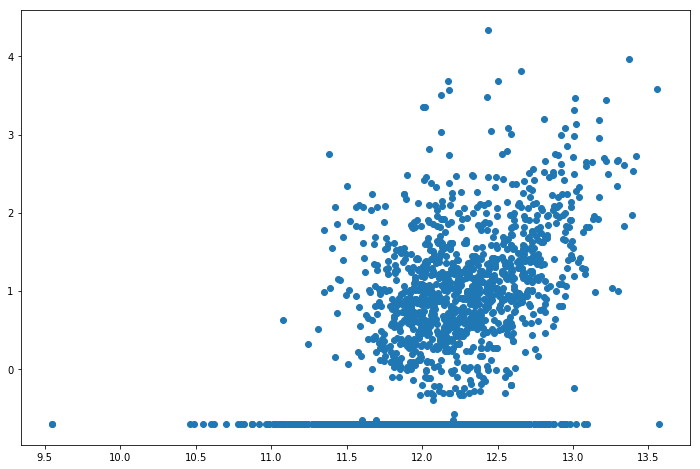

In [208]:
fig, ax = plt.subplots(figsize=(12,8))

scyler = StandardScaler()



drizzt = raw_data.loc[:,"Mas Vnr Area"] + 1
drizzt.fillna(1, inplace=True)

drizzt = drizzt**0.5

scaled = scyler.fit_transform(drizzt)
ax.scatter(np.log(Y), scaled)
# ax.scatter(np.log(Y), drizzt, s=100, alpha=0.2)